<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/App_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
linkedin_data = pd.read_csv("/content/linkedin-reviews.csv")

# Display the first few rows of the dataset
print(linkedin_data.head())

                                              Review  Rating
0  Does absolutely nothing for a LinkedIn beginne...       1
1                            Force close(galaxy tab)       1
2  Slow and it tries to upload your contacts with...       1
3  Add ability to customize the profile and move ...       4
4  Good app, but it's a pain that it's not possib...       4


In [ ]:
print(linkedin_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  702 non-null    object
 1   Rating  702 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB
None


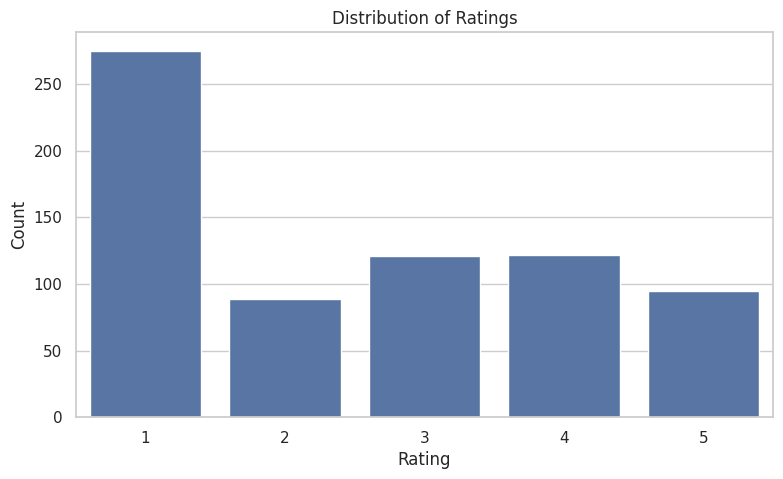

In [ ]:
# Plotting the distribution of ratings
sns.set(style="whitegrid")
plt.figure(figsize=(9, 5))
sns.countplot(data=linkedin_data, x='Rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

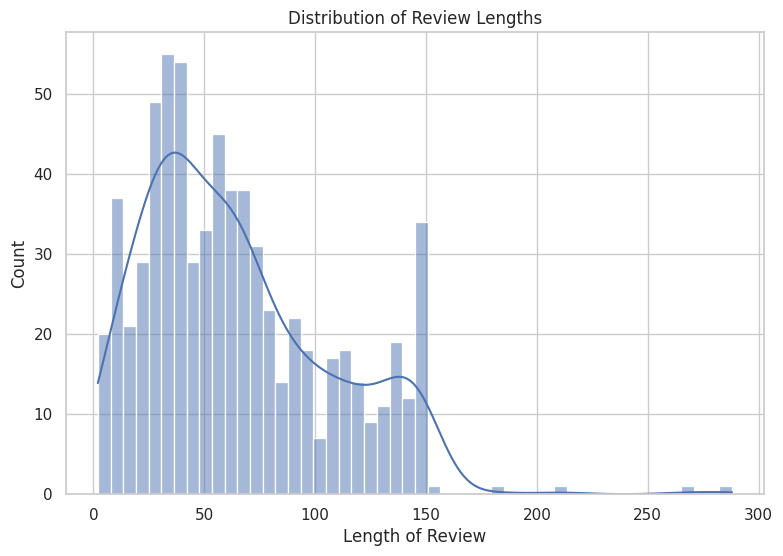

In [ ]:
# Calculating the length of each review
linkedin_data['Review Length'] = linkedin_data['Review'].apply(len)

# Plotting the distribution of review lengths
plt.figure(figsize=(9, 6))
sns.histplot(linkedin_data['Review Length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Count')
plt.show()

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

def textblob_sentiment_analysis(review):
    # Analyzing the sentiment of the review
    sentiment = TextBlob(review).sentiment
    # Classifying based on polarity
    if sentiment.polarity > 0.1:
        return 'Positive'
    elif sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Applying TextBlob sentiment analysis to the reviews
linkedin_data['Sentiment'] = linkedin_data['Review'].apply(textblob_sentiment_analysis)

# Displaying the first few rows with the sentiment
print(linkedin_data.head())

                                              Review  Rating  Review Length  \
0  Does absolutely nothing for a LinkedIn beginne...       1             80   
1                            Force close(galaxy tab)       1             23   
2  Slow and it tries to upload your contacts with...       1             61   
3  Add ability to customize the profile and move ...       4             90   
4  Good app, but it's a pain that it's not possib...       4            133   

  Sentiment  
0  Negative  
1   Neutral  
2  Negative  
3   Neutral  
4  Positive  


In [ ]:
!pip install plotly
import plotly.express as px # Import the plotly.express module and alias it as px

# filter reviews with negative sentiment
negative_reviews = linkedin_data[linkedin_data['Sentiment'] == 'Negative']['Review']

# use CountVectorizer to extract common phrases (n-grams) for negative reviews
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_neg = vectorizer.fit_transform(negative_reviews)

# sum the counts of each phrase in negative reviews
phrase_counts_neg = X_neg.sum(axis=0)
phrases_neg = vectorizer.get_feature_names_out()
phrase_freq_neg = [(phrases_neg[i], phrase_counts_neg[0, i]) for i in range(len(phrases_neg))]

# sort phrases by frequency
phrase_freq_neg = sorted(phrase_freq_neg, key=lambda x: x[1], reverse=True)

phrase_neg_df = pd.DataFrame(phrase_freq_neg, columns=['Phrase', 'Frequency'])

# Change phrase_neg_linkedin_data to phrase_neg_df
fig = px.bar(phrase_neg_df, # using the correct dataframe name
             x='Frequency',
             y='Phrase',
             orientation='h',
             title='Top Common Phrases in Negative Reviews',
             labels={'Phrase': 'Phrase', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Phrase',
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [ ]:
# grouping similar phrases into broader problem categories
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}

# initialize a dictionary to count problems
problem_counts = {key: 0 for key in problem_keywords.keys()}

# count occurrences of problem-related phrases in negative reviews
for phrase, count in phrase_freq_neg:
    for problem, keywords in problem_keywords.items():
        if any(keyword in phrase for keyword in keywords):
            problem_counts[problem] += count
            break

problem_df = pd.DataFrame(list(problem_counts.items()), columns=['Problem', 'Frequency'])

fig = px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h',
             title='Common Problems Faced by Users in ChatGPT',
             labels={'Problem': 'Problem', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title='Frequency',
    yaxis_title='Problem',
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [ ]:
# convert 'Review Date' to datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'])

# aggregate sentiment counts by date
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

# convert the period back to datetime for plotting
sentiment_over_time.index = sentiment_over_time.index.to_timestamp()

fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()

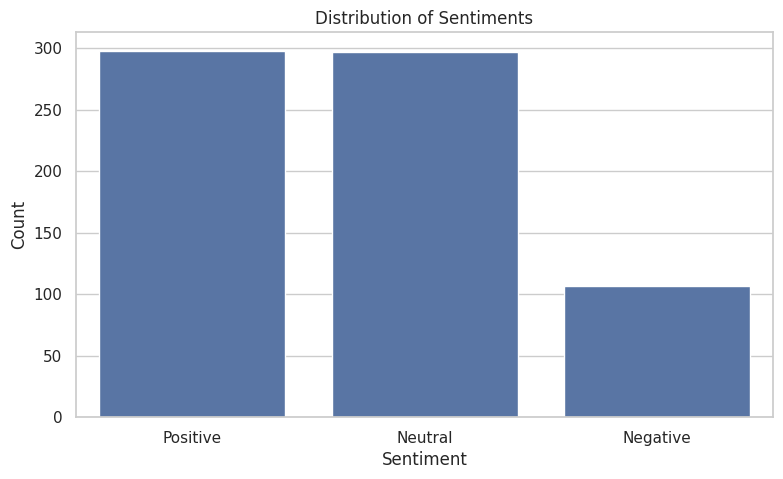

In [ ]:
# Analyzing the distribution of sentiments
sentiment_distribution = linkedin_data['Sentiment'].value_counts()

# Plotting the distribution of sentiments
plt.figure(figsize=(9, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

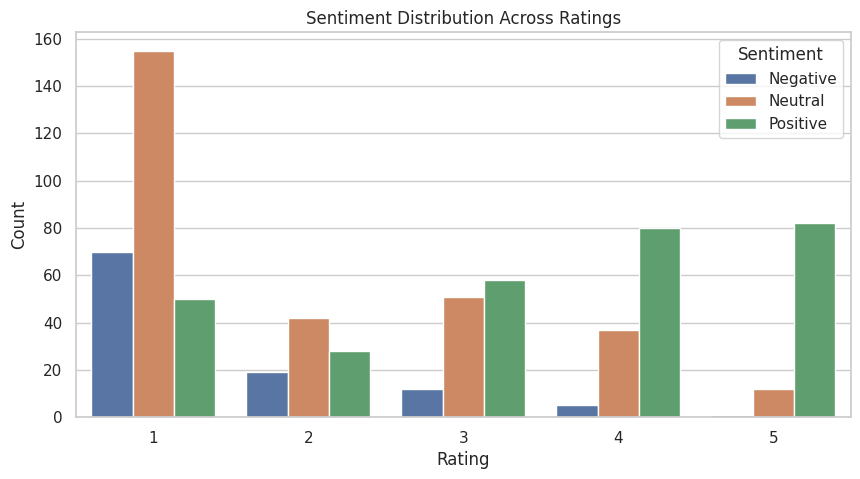

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=linkedin_data, x='Rating', hue='Sentiment')
plt.title('Sentiment Distribution Across Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

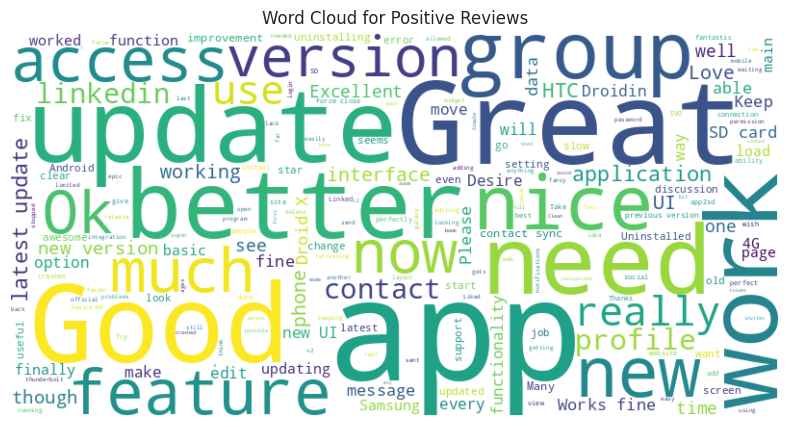

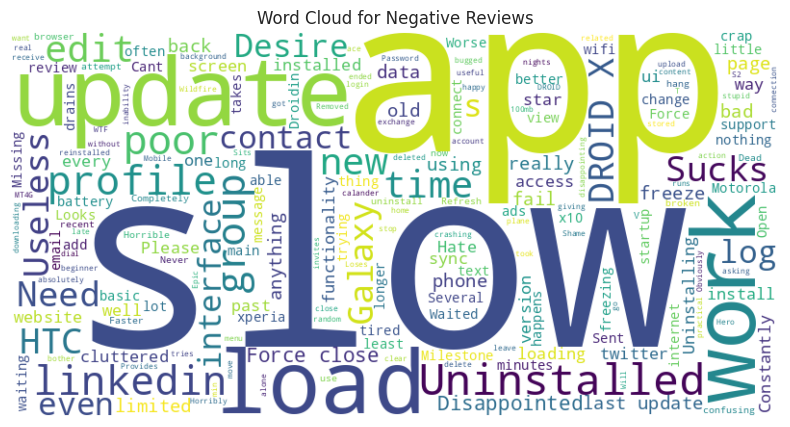

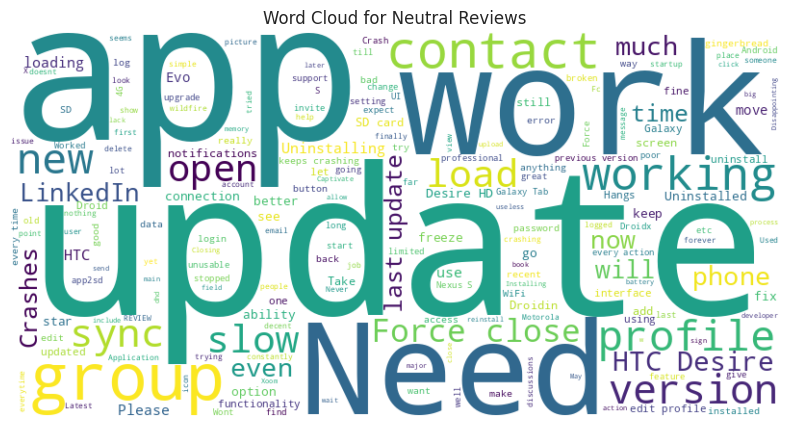

In [ ]:
from wordcloud import WordCloud

# Function to generate word cloud for each sentiment
def generate_word_cloud(sentiment):
    text = ' '.join(review for review in linkedin_data[linkedin_data['Sentiment'] == sentiment]['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.axis('off')
    plt.show()

# Generating word clouds for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    generate_word_cloud(sentiment)